## Load necessary modules

In [1]:
# show images inline
%matplotlib inline

# automatically reload modules when they have changed
%load_ext autoreload
%autoreload 2

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

# import keras
import keras

# import keras_retinanet
#from keras_retinanet.models.resnet import custom_objects
from keras_retinanet import models
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image

# import miscellaneous modules
import matplotlib.pyplot as plt
import cv2
import numpy as np
import time

# set tf backend to allow memory to grow, instead of claiming everything
import tensorflow as tf

def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    return tf.Session(config=config)

# use this environment flag to change which GPU to use
#os.environ["CUDA_VISIBLE_DEVICES"] = "1"

# set the modified tf session as backend in keras
keras.backend.tensorflow_backend.set_session(get_session())



from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color


Using TensorFlow backend.


## Load RetinaNet model

In [2]:
# adjust this to point to your downloaded/trained model
model_path = os.path.join('snapshots', 'ccc_resnet50_csv_01_inference.h5')

# load retinanet model
model = models.load_model(model_path,backbone_name='resnet50')
#print(model.summary())

# load label to names mapping for visualization purposes
labels_to_names = {0: 'Casco',1: 'Rostro'}

C:\Users\Hp\Anaconda3\envs\AAAA\lib\site-packages\keras\engine\saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


## Run detection on example

In [5]:
import colorsys
import random
N = len(labels_to_names)
HSV_tuples = [(x*1.0/N, 0.5, 0.5) for x in range(N)]
RGB_tuples = list(map(lambda x: tuple(255*np.array(colorsys.hsv_to_rgb(*x))), HSV_tuples))
random.shuffle(RGB_tuples)


In [6]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.physical_device_desc for x in local_device_protos if x.device_type == 'GPU']

GPU = get_available_gpus()
print(GPU)

['device: 0, name: GeForce MX130, pci bus id: 0000:01:00.0, compute capability: 5.0']


In [12]:
cap = cv2.VideoCapture('/test/minero4.MOV')

counter = 0
sum_time=0
while(True):
    ret, draw = cap.read()
    if not ret:
        break
    bgr = cv2.cvtColor(draw, cv2.COLOR_RGB2BGR)
    
    # preprocess image for network
    image = preprocess_image(bgr)
    image, scale = resize_image(image)
    # process image
    start = time.time()
    _, _, detections = model.predict_on_batch(np.expand_dims(image, axis=0))
    t = time.time() - start
#     print("processing time: ", t)

    # compute predicted labels and scores
    predicted_labels = np.argmax(detections[0, :, 4:], axis=1)
    scores = detections[0, np.arange(detections.shape[1]), 4 + predicted_labels]

    # correct for image scale
    detections[0, :, :4] /= scale

    # visualize detections
    for idx, (label, score) in enumerate(zip(predicted_labels, scores)):
        if score < 0.5:
            continue
        b = detections[0, idx, :4].astype(int)
        cv2.rectangle(draw, (b[0], b[1]), (b[2], b[3]), RGB_tuples[label], 6)
        caption = "%s: %.1f%%"%(labels_to_names[label], score*100)
        cv2.putText(draw, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 5)
        cv2.putText(draw, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
        if sum_time>0:
            cv2.putText(draw, "%s Processing time %.2fs (%.1ffps)  AVG %.2fs (%.1ffps)"%(GPU, t,1.0/t,sum_time/counter,counter/sum_time), (50, 100), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 0), 7)
            cv2.putText(draw, "%s Processing time %.2fs (%.1ffps)  AVG %.2fs (%.1ffps)"%(GPU, t,1.0/t,sum_time/counter,counter/sum_time), (50, 100), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 255, 255), 3)
    cv2.imwrite('/tmp/img%08d.jpg'%counter,draw)
    counter=counter+1
    sum_time+=t

cap.release()
cv2.destroyAllWindows()


In [38]:
cap = cv2.VideoCapture('test/minero4.MOV')

counter = 0
sum_time=0
while(True):
    ret, draw = cap.read()
    if not ret:
        break
    bgr = cv2.cvtColor(draw, cv2.COLOR_RGB2BGR)
    
    # preprocess image for network
    image = preprocess_image(bgr)
    image, scale = resize_image(image)
    
    # process image
    start = time.time()
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))
    #print("processing time: ", time.time() - start)
    t = time.time() - start

    # correct for image scale
    boxes /= scale

    # visualize detections
    for box, score, label in zip(boxes[0], scores[0], labels[0]):
        # scores are sorted so we can break
        if score < 0.5:
            break

        color = label_color(label)

        b = box.astype(int)
        cv2.rectangle(draw, (b[0], b[1]), (b[2], b[3]), (0, 0, 255), 3)
        caption = "{} {:.3f}".format(labels_to_names[label], score)
        cv2.putText(draw, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1.5, (0, 0, 0), 3)
        cv2.putText(draw, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1.5, (255, 255, 255), 2)
        if sum_time>0:
            cv2.putText(draw, "%s Processing time %.2fs (%.1ffps)  AVG %.2fs (%.1ffps)"%(GPU, t,1.0/t,sum_time/counter,counter/sum_time), (50, 100), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 0), 7)
            cv2.putText(draw, "%s Processing time %.2fs (%.1ffps)  AVG %.2fs (%.1ffps)"%(GPU, t,1.0/t,sum_time/counter,counter/sum_time), (50, 100), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 255, 255), 3)
    cv2.imwrite('tmp/img%08d.jpg'%counter,draw)
    counter=counter+1
    sum_time+=t

cap.release()
cv2.destroyAllWindows()

In [50]:
cap = cv2.VideoCapture(0)

font = cv2.FONT_HERSHEY_PLAIN
starting_time = time.time()
frame_id = 0
while True:
    ret, frame = cap.read()
    frame_id += 1

    if not ret:
        break
    bgr = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
    
    # preprocess image for network
    image = preprocess_image(bgr)
    image, scale = resize_image(image)
    

    start = time.time()
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))
    #print("processing time: ", time.time() - start)
    t = time.time() - start
    
    
    # correct for image scale
    boxes /= scale

    # visualize detections
    for box, score, label in zip(boxes[0], scores[0], labels[0]):
        # scores are sorted so we can break
        if score < 0.3:
            break

        color = label_color(label)

        b = box.astype(int)
        cv2.rectangle(frame, (b[0], b[1]), (b[2], b[3]), (0, 0, 255), 3)
        caption = "{} {:.3f}".format(labels_to_names[label], score)
        cv2.putText(frame, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1.5, (0, 0, 0), 3)
        cv2.putText(frame, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1.5, (255, 255, 255), 2)

    elapsed_time = time.time() - starting_time
    fps = frame_id / elapsed_time
    cv2.putText(frame, "FPS: " + str(round(fps, 2)), (10, 50), font, 4, (0, 0, 0), 3)
    cv2.imshow("Image", frame)
    key = cv2.waitKey(1)
    if key == 27:
        break

cap.release()
cv2.destroyAllWindows()

KeyboardInterrupt: 

processing time:  1.2032191753387451


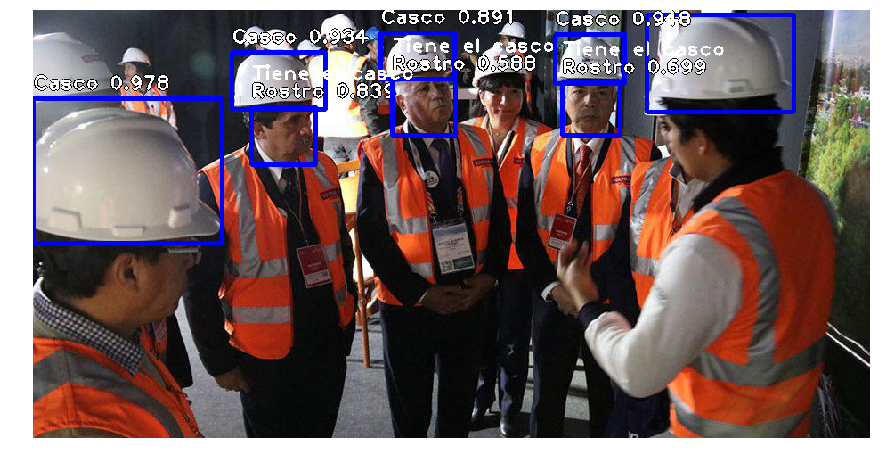

[ 57.775055 252.51686  180.95485  359.56696 ]


In [4]:
# load image
image = read_image_bgr('test/image_18.jpg')

# copy to draw on
draw = image.copy()
draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

# preprocess image for network
image = preprocess_image(image)
image, scale = resize_image(image)

# process image
start = time.time()
boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))
print("processing time: ", time.time() - start)

# correct for image scale
boxes /= scale
label_1=[]
scores_1=[]
boxes_1=[]

# visualize detections
for box, score, label in zip(boxes[0], scores[0], labels[0]):
    # scores are sorted so we can break
    if score < 0.5:
        break
    
    boxes_1.append(box)
    scores_1.append(score)
    label_1.append(label)

import pandas as pd
df=pd.DataFrame()
df['label']=label_1
df['scores']=scores_1
df['boxes']=boxes_1

filtro=df['label']==1
df_ro=df[filtro]
filtro_c=df['label']==0
df_ca=df[filtro_c]

for i in range(len(df_ca)):
    coorde=df_ca.iloc[i][2]
    dt_fr_ca=df_ca.iloc[i]
        
    color_c = label_color(dt_fr_ca[0])
    b_c = dt_fr_ca[2].astype(int)
    cv2.rectangle(draw, (b_c[0], b_c[1]), (b_c[2], b_c[3]), (0, 0, 255), 3)
    caption_c = "{} {:.3f}".format(labels_to_names[dt_fr_ca[0]], dt_fr_ca[1])
    cv2.putText(draw, caption_c, (b_c[0], b_c[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1.5, (0, 0, 0), 3)
    cv2.putText(draw, caption_c, (b_c[0], b_c[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1.5, (255, 255, 255), 2)
        
for j in range(len(df_ro)):
    coorde_ro=df_ro.iloc[j][2]
    dt_fr_ro=df_ro.iloc[j]
                             
    color = label_color(dt_fr_ro[0])
    b = dt_fr_ro[2].astype(int)
    cv2.rectangle(draw, (b[0], b[1]), (b[2], b[3]), (0, 0, 255), 3)
    caption = "{} {:.3f}".format(labels_to_names[dt_fr_ro[0]], dt_fr_ro[1])
    cv2.putText(draw, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1.5, (0, 0, 0), 3)
    cv2.putText(draw, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1.5, (255, 255, 255), 2)    

counter = 0               
for k in range(len(df_ro)):
    coorde_ro=df_ro.iloc[k][2]
    dt_fr_ro=df_ro.iloc[k]
    texto=''
    for l in range(len(df_ca)):
        valor=True
        coorde=df_ca.iloc[l][2]
        if (coorde[3]-coorde_ro[1])<50 and (coorde[0]-coorde_ro[0])<50 and (coorde[3]-coorde_ro[1])>-50 and (coorde[0]-coorde_ro[0])>-50:
            texto='Tiene el casco'
            break

        else:
            texto='No tiene'

    b_d = dt_fr_ro[2].astype(int)
    cv2.putText(draw, texto, (b_d[0], b_d[1] - 30), cv2.FONT_HERSHEY_PLAIN, 1.5, (255, 255, 255), 2)
    
    if texto=='No tiene':
        cv2.imwrite('tmp/img%08d.jpg'%counter,draw)
    counter += 1


                  
            
plt.figure(figsize=(15, 15))
plt.axis('off')
plt.imshow(draw)
plt.show()

print(box)

In [ ]:
if 1 in label_1 and 0 in label_1:
    for box2, score2, label2 in zip(boxes_1, scores_1, label_1):
               
        color = label_color(label2)

        b = box2.astype(int)

        cv2.rectangle(draw, (b[0], b[1]), (b[2], b[3]), (0, 0, 255), 3)
        caption = "{} {:.3f}".format(labels_to_names[label2], score2)
        cv2.putText(draw, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1.5, (0, 0, 0), 3)
        cv2.putText(draw, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1.5, (255, 255, 255), 2)
            
        
    if df.iloc[0][0]==0:
        variablec_ab=df.iloc[0][2][3]
        variablec_iz=df.iloc[0][2][0]
        variablec_derecha=df.iloc[0][2][2]
        variabler_ar=df.iloc[1][2][1]
        variabler_iz=df.iloc[1][2][0]
        variabler_derecha=df.iloc[1][2][2]
            
        if (variablec_ab-variabler_ar)<50 and (variablec_iz-variabler_iz)<50 and (variablec_ab-variabler_ar)>-50 and (variablec_iz-variabler_iz)>-50 :
            texto='Tiene el casco puesto'
            cv2.putText(draw, texto, (10, 10), cv2.FONT_HERSHEY_PLAIN, 1.5, (255, 255, 255), 2)
        else:
            texto='No Tiene el casco puesto'
            cv2.putText(draw, texto, (10, 10), cv2.FONT_HERSHEY_PLAIN, 1.5, (255, 255, 255), 2)

    elif df.iloc[0][0]==1:
        variablec_ab=df.iloc[1][2][3]
        variablec_iz=df.iloc[1][2][0]
        variablec_derecha=df.iloc[1][2][2]
        variabler_ar=df.iloc[0][2][1]
        variabler_iz=df.iloc[0][2][0]
        variabler_derecha=df.iloc[0][2][2]
            
        if (variablec_ab-variabler_ar)<50 and (variablec_iz-variabler_iz)<50 and (variablec_ab-variabler_ar)>-50 and (variablec_iz-variabler_iz)>-50:
            texto='Tiene el casco puesto'
            cv2.putText(draw, texto, (10, 20), cv2.FONT_HERSHEY_PLAIN, 1.5, (255, 255, 255), 2)
        else:
            texto='No Tiene el casco puesto'
            cv2.putText(draw, texto, (10, 20), cv2.FONT_HERSHEY_PLAIN, 1.5, (255, 255, 255), 2)
                
    else:
        texto=' No se sabe'
        cv2.putText(draw, texto, (10, 20), cv2.FONT_HERSHEY_PLAIN, 1.5, (255, 255, 255), 2)

else:
        texto='No se reconoce nada'
        cv2.putText(draw, texto, (10, 20), cv2.FONT_HERSHEY_PLAIN, 1.5, (255, 255, 255), 2)

    
    
            
       

In [16]:
cap = cv2.VideoCapture('test/minero4.MOV')

counter = 0
sum_time=0
while(True):
    ret, draw = cap.read()
    if not ret:
        break
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

    # preprocess image for network
    image = preprocess_image(draw)
    image, scale = resize_image(image)

    # process image
    start = time.time()
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))
    #print("processing time: ", time.time() - start)
    t = time.time() - start

    # correct for image scale
    boxes /= scale
    plt.figure(figsize=(20,12))
    plt.imshow(draw)
    
    current_axis = plt.gca()
    colors = plt.cm.hsv(np.linspace(0, 1, 1+1)).tolist()
    
    for box, score, label in zip(boxes[0], scores[0], labels[0]):
        # scores are sorted so we can break
        if score < 0.5:
            break

        xmin = box[0].astype(int)
        ymin = box[1].astype(int)
        xmax = box[2].astype(int)
        ymax = box[3].astype(int)
        
        label = '{}: {:.2f}'.format(labels_to_names[label], score)
        current_axis.add_patch(plt.Rectangle((xmin, ymin), (xmax-xmin), (ymax-ymin), color='green', fill=False, linewidth=2))  
        current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':'green', 'alpha':1.0})
            
   
    plt.axis('off')
    plt.savefig('prueba/img%08d.jpg'%counter)
    #cv2.imwrite('tmp/img%08d.jpg'%counter,draw)
    counter=counter+1
    sum_time+=t

cap.release()
cv2.destroyAllWindows()

KeyboardInterrupt: 

In [ ]:
cap = cv2.VideoCapture(0)
salida = cv2.VideoWriter('videoSalida.avi',cv2.VideoWriter_fourcc(*'XVID'),20.0,(640,480))

font = cv2.FONT_HERSHEY_PLAIN
starting_time = time.time()
frame_id = 0
while True:
    ret, frame = cap.read()
    frame_id += 1

    if not ret:
        break
    bgr = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
    
    # preprocess image for network
    image = preprocess_image(bgr)
    image, scale = resize_image(image)
    

    start = time.time()
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))
    #print("processing time: ", time.time() - start)
    t = time.time() - start
    
    
    # correct for image scale
    boxes /= scale

    # visualize detections
    for box, score, label in zip(boxes[0], scores[0], labels[0]):
        # scores are sorted so we can break
        if score < 0.5:
            break

        color = label_color(label)

        b = box.astype(int)
        cv2.rectangle(frame, (b[0], b[1]), (b[2], b[3]), (0, 0, 255), 3)
        caption = "{} {:.3f}".format(labels_to_names[label], score)
        cv2.putText(frame, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1.5, (0, 0, 0), 3)
        cv2.putText(frame, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1.5, (255, 255, 255), 2)

    elapsed_time = time.time() - starting_time
    fps = frame_id / elapsed_time
    cv2.putText(frame, "FPS: " + str(round(fps, 2)), (10, 50), font, 4, (0, 0, 0), 3)
    cv2.imshow("Image", frame)
    salida.write(frame)
    key = cv2.waitKey(1)
    if key == 27:
        break

cap.release()
salida.release()
cv2.destroyAllWindows()

In [12]:
cap = cv2.VideoCapture('test/minero.mp4')
salida = cv2.VideoWriter('videoSalida1.avi',cv2.VideoWriter_fourcc(*'XVID'),3,(640,480))
counter = 0
sum_time=0
while(True):
    ret, draw = cap.read()
    if not ret:
        break
    bgr = cv2.cvtColor(draw, cv2.COLOR_RGB2BGR)
    
    # preprocess image for network
    image = preprocess_image(bgr)
    image, scale = resize_image(image)
    
    # process image
    start = time.time()
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))
    #print("processing time: ", time.time() - start)
    t = time.time() - start

    # correct for image scale
    boxes /= scale

    # visualize detections
    for box, score, label in zip(boxes[0], scores[0], labels[0]):
        # scores are sorted so we can break
        if score < 0.5:
            break

        color = label_color(label)

        b = box.astype(int)
        cv2.rectangle(draw, (b[0], b[1]), (b[2], b[3]), (0, 0, 255), 3)
        caption = "{} {:.3f}".format(labels_to_names[label], score)
        cv2.putText(draw, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1.5, (0, 0, 0), 3)
        cv2.putText(draw, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1.5, (255, 255, 255), 2)
    
    cv2.imshow("Image", draw)
    salida.write(draw)
    
    counter=counter+1
    sum_time+=t

cap.release()
salida.release()
cv2.destroyAllWindows()

In [13]:
cap = cv2.VideoCapture('test/minero.mp4')
salida = cv2.VideoWriter('videoSalidall.avi',cv2.VideoWriter_fourcc(*'XVID'),20.0,(640,480))

font = cv2.FONT_HERSHEY_PLAIN
starting_time = time.time()
frame_id = 0
while True:
    ret, frame = cap.read()
    frame_id += 1

    if not ret:
        break
    bgr = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
    
    # preprocess image for network
    image = preprocess_image(bgr)
    image, scale = resize_image(image)
    

    start = time.time()
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))
    #print("processing time: ", time.time() - start)
    t = time.time() - start
    
    
    # correct for image scale
    boxes /= scale

    # visualize detections
    for box, score, label in zip(boxes[0], scores[0], labels[0]):
        # scores are sorted so we can break
        if score < 0.5:
            break

        color = label_color(label)

        b = box.astype(int)
        cv2.rectangle(frame, (b[0], b[1]), (b[2], b[3]), (0, 0, 255), 3)
        caption = "{} {:.3f}".format(labels_to_names[label], score)
        cv2.putText(frame, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1.5, (0, 0, 0), 3)
        cv2.putText(frame, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1.5, (255, 255, 255), 2)

    elapsed_time = time.time() - starting_time
    fps = frame_id / elapsed_time
    cv2.putText(frame, "FPS: " + str(round(fps, 2)), (10, 50), font, 4, (0, 0, 0), 3)
    cv2.imshow("Image", frame)
    salida.write(frame)
    key = cv2.waitKey(1)
    if key == 27:
        break

cap.release()
salida.release()
cv2.destroyAllWindows()

KeyboardInterrupt: 